In [116]:
%matplotlib inline

In [119]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [381]:
df = pd.read_csv('yelp_combined.csv')

############ Delete later ##################
df.dropna(subset=['recent_reviews','avg_rating', 'category'], inplace=True)
df = df[df.num_reviews >= 10]
df.recent_reviews = df.recent_reviews.map(lambda x: ast.literal_eval(x))
df.business_hours = df.business_hours.map(lambda x: ast.literal_eval(x))
df.covid_services = df.covid_services.map(lambda x: ast.literal_eval(x))
df.category = df.category.map(lambda x: x.split(','))

In [785]:
df = pd.read_csv('yelp_combined.csv')

In [786]:
df.head()

,address,avg_rating,business_hours,category,covid_services,covid_update_time,covid_updates_text,cuisine,location,num_reviews,phone_num,price_range,recent_reviews,restaurant_name,url
0,"1283 9th Ave, San Francisco, CA 94122",4.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': '11:...","Sushi Bars,Japanese",{'Takeout': True},"Posted on May 27, 2020","""We are currently open for TAKEOUT only on Wed...",japanese,"San Francisco, CA",1804,(415) 566-1770,$$,"[('5 star rating', '7/22/2020'), ('4 star rati...",Ebisu,https://www.yelp.com/biz/ebisu-san-francisco?o...
1,"2450 Clement St, San Francisco, CA 94121",4.0,"{'Mon': '4:00 pm - 8:30 pm', 'Tue': 'Closed', ...","Japanese,Sushi Bars","{'Delivery': True, 'Takeout': True}","Posted on April 26, 2020","""Sorry to keep you waiting. We finally finishe...",japanese,"San Francisco, CA",508,(415) 386-8008,$$,"[('5 star rating', '7/4/2020'), ('5 star ratin...",Daigo Sushi,https://www.yelp.com/biz/daigo-sushi-san-franc...
2,"310 Linden Ave, South San Francisco, CA 94080",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","Sushi Bars,Japanese","{'Delivery': True, 'Takeout': True}",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",710,(650) 873-1084,$$,"[('1 star rating', '7/16/2020'), ('5 star rati...",Amami San Sushi,https://www.yelp.com/biz/amami-san-sushi-south...
3,"307 Kearny St, Ste 204, San Francisco, CA 94108",4.0,"{'Mon': '11:00 am - 7:00 pm', 'Tue': '11:00 am...",Japanese Curry,"{'Outdoor seating': True, 'Delivery': True, 'T...",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",1722,(415) 773-1101,$$,"[('2 star rating', '7/16/2020'), ('5 star rati...",Muracci's Japanese Curry & Grill,https://www.yelp.com/biz/muraccis-japanese-cur...
4,"3409 Geary Blvd, San Francisco, CA 94118",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","Sushi Bars,Ramen,Izakaya","{'Delivery': True, 'Takeout': True}","Posted on June 7, 2020","""We are currently open for TAKE OUT,We offer L...",japanese,"San Francisco, CA",768,(415) 742-4309,$$,"[('5 star rating', '7/20/2020'), ('5 star rati...",Kaiju Eats Ramen and Izakaya,https://www.yelp.com/biz/kaiju-eats-ramen-and-...


In [704]:
df.shape

(4936, 15)

In [705]:
df.dtypes

address                object
avg_rating            float64
business_hours         object
category               object
covid_services         object
covid_update_time      object
covid_updates_text     object
cuisine                object
location               object
num_reviews             int64
phone_num              object
price_range            object
recent_reviews         object
restaurant_name        object
url                    object
dtype: object

### Handling Missin Data

In [787]:
np.sum(df.isnull())

address                 2
avg_rating             30
business_hours          0
category                2
covid_services          0
covid_update_time     135
covid_updates_text    160
cuisine                 0
location                0
num_reviews             0
phone_num             128
price_range           504
recent_reviews         70
restaurant_name         2
url                     0
dtype: int64

- Dropping rows with missing avg_rating, recent_reviews or category since the analysis centers around those variables

In [788]:
df.dropna(subset=['recent_reviews','avg_rating', 'category'], inplace=True)
df.shape

(4866, 15)

In [789]:
# Also filtering out rows where num_review <10 
df = df[df.num_reviews >= 10]
df.shape

(4742, 15)

### Data Cleaning & Variable Type Conversion

In [710]:
df.loc[[0]].dtypes

address                object
avg_rating            float64
business_hours         object
category               object
covid_services         object
covid_update_time      object
covid_updates_text     object
cuisine                object
location               object
num_reviews             int64
phone_num              object
price_range            object
recent_reviews         object
restaurant_name        object
url                    object
dtype: object

In [711]:
print(type(df.business_hours[0]))
print(type(df.covid_services[0]))
print(type(df.recent_reviews[0]))

<class 'str'>
<class 'str'>
<class 'str'>


In [712]:
import ast
ast.literal_eval(df.recent_reviews[0])
print(type(ast.literal_eval(df.business_hours[0])))
print(type(ast.literal_eval(df.covid_services[0])))
print(type(ast.literal_eval(df.recent_reviews[0])))


<class 'dict'>
<class 'dict'>
<class 'list'>


In [790]:
df.recent_reviews = df.recent_reviews.apply(lambda x: ast.literal_eval(x))
df.business_hours = df.business_hours.apply(lambda x: ast.literal_eval(x))
df.covid_services = df.covid_services.apply(lambda x: ast.literal_eval(x))

In [791]:
df.category = df.category.map(lambda x: x.split(','))

In [792]:
df.price_range.head(5)

0    $$
1    $$
2    $$
3    $$
4    $$
Name: price_range, dtype: object

In [793]:
np.sum(df.isnull())

address                 0
avg_rating              0
business_hours          0
category                0
covid_services          0
covid_update_time      36
covid_updates_text    105
cuisine                 0
location                0
num_reviews             0
phone_num              86
price_range           321
recent_reviews          0
restaurant_name         0
url                     0
dtype: int64

In [780]:
df.price_range = df['price_range'].to_string()

In [781]:
# Convert price range to integer value 

df.price_range = df.price_range.map(lambda x: len(x) if x!='' else np.nan)


In [782]:
df.price_range.mean()

61645.0

### Derive new columns

In [731]:
df.head(3)

,address,avg_rating,business_hours,category,covid_services,covid_update_time,covid_updates_text,cuisine,location,num_reviews,phone_num,price_range,recent_reviews,restaurant_name,url
0,"1283 9th Ave, San Francisco, CA 94122",4.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': '11:...","[Sushi Bars, Japanese]",{'Takeout': True},"Posted on May 27, 2020","""We are currently open for TAKEOUT only on Wed...",japanese,"San Francisco, CA",1804,(415) 566-1770,$$,"[(5 star rating, 7/22/2020), (4 star rating, 7...",Ebisu,https://www.yelp.com/biz/ebisu-san-francisco?o...
1,"2450 Clement St, San Francisco, CA 94121",4.0,"{'Mon': '4:00 pm - 8:30 pm', 'Tue': 'Closed', ...","[Japanese, Sushi Bars]","{'Delivery': True, 'Takeout': True}","Posted on April 26, 2020","""Sorry to keep you waiting. We finally finishe...",japanese,"San Francisco, CA",508,(415) 386-8008,$$,"[(5 star rating, 7/4/2020), (5 star rating, 7/...",Daigo Sushi,https://www.yelp.com/biz/daigo-sushi-san-franc...
2,"310 Linden Ave, South San Francisco, CA 94080",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","[Sushi Bars, Japanese]","{'Delivery': True, 'Takeout': True}",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",710,(650) 873-1084,$$,"[(1 star rating, 7/16/2020), (5 star rating, 7...",Amami San Sushi,https://www.yelp.com/biz/amami-san-sushi-south...


- New column variables: count of recent ratings (after 3/1/2020) and avg_recent_rating

In [794]:
def split_recent_reviews(rr, date_cut = pd.to_datetime('3/1/2020')):
    try:
        ratings, dates = zip(*rr)
    except Exception as e:
        print(f"Trouble with {rr} here is: {e}")
        return pd.Series(dict(mean_rating = np.nan, n_ratings = np.nan))
    dates = pd.to_datetime(dates)
    keep_idxs = dates >= date_cut
    ratings = pd.Series(ratings)[keep_idxs].apply(lambda x: int(x[0]))
    dates = dates[keep_idxs]
    mean_rating = ratings.mean()
    n_ratings = ratings.shape[0]
    return pd.Series(dict(mean_rating = mean_rating, n_ratings = n_ratings))

In [795]:
df[['recent_rating','num_recent_rating']] = df.recent_reviews.apply(split_recent_reviews)[['mean_rating','n_ratings']]

In [796]:
df[df.num_recent_rating >3].shape

(3387, 17)

In [ ]:
# # Convert recent reviews to the correct data types: float and datetime and compute recent average review rating
# # Recent defined as after 3/1/2020

# from datetime import datetime
# for i in range(df.shape[0]):
#     for x in range(len(df.recent_reviews.loc[i])):
#         df.recent_reviews.loc[i][x] = list(df.recent_reviews.loc[i][x])
#         df.recent_reviews.loc[i][x][0] = float(item[0].replace(' star rating', ''))
#         df.recent_reviews.loc[i][x][1] = datetime.strptime(item[1], '%m/%d/%Y')

- Create Covid service related columns: delivery, takeout, outdoor_seating, sit-down_dining, curbside_pickup, safety_measure as boolean variable 

In [797]:
df['delivery'] = df.covid_services.map(lambda x: "Delivery" in x.keys() and x['Delivery']==True)
df['takeout'] = df.covid_services.map(lambda x: "Takeout" in x.keys() and x['Takeout'] ==True)
df['outdoor_seating'] = df.covid_services.map(lambda x: "Outdoor seating" in x.keys() and x['Outdoor seating'] ==True)
df['sit-down_dining'] = df.covid_services.map(lambda x: "Sit-down dining" in x.keys() and x['Sit-down dining'] ==True)
df['curbside_pickup'] = df.covid_services.map(lambda x: "Curbside pickup" in x.keys() and x['Curbside pickup'] ==True)
df['safety_measure'] = df.covid_services.map(lambda x: set(x.keys()) & \
    set(['Contactless payments', 'Masks required', 'Staff wears gloves', 'Staff wears masks', \
         'Limited capacity', 'Hand sanitizer provided', 'Social distancing enforced', 'Temperature checks']) != set())


In [804]:
# Filtering out rows where number of recent rating = 0
df = df[df.num_recent_rating > 0]
df.shape

(4484, 23)

- Create new variable delta_rating

In [806]:
df['delta_rating'] = df['recent_rating'] - df['avg_rating']

(array([  22.,   22.,   44.,  127.,  426., 1439., 1656.,  609.,  124.,
          15.]),
 array([-3.5, -2.9, -2.3, -1.7, -1.1, -0.5,  0.1,  0.7,  1.3,  1.9,  2.5]),
 <a list of 10 Patch objects>)

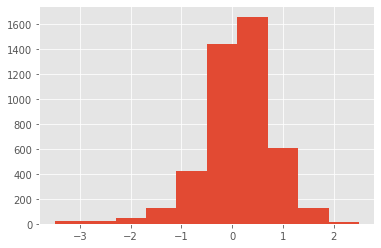

In [808]:
plt.hist(df.delta_rating)

### Exploratory Data Analysis 

- By cuisine type 

In [665]:
group = df.groupby('cuisine')

In [ ]:
group.agg('mean')['delivery']

In [ ]:
data[data['item'] == 'call'].groupby('month').agg(
    # Get max of the duration column for each group
    max_duration=('duration', max),
    # Get min of the duration column for each group
    min_duration=('duration', min),
    # Get sum of the duration column for each group
    total_duration=('duration', sum),
    # Apply a lambda to date column
    num_days=("date", lambda x: (max(x) - min(x)).days)    
)

In [672]:
df.delivery.count()

4421

In [676]:
group.agg(percent_delivery=("delivery", lambda x: x[x==True].count()/x.count()),
         percent_takeout =("takeout", lambda x: x[x==True].count()/x.count()),
        percent_outdoor_seating =("outdoor_seating", lambda x: x[x==True].count()/x.count()),
         percent_safety_measure = ("safety_measure", lambda x: x[x==True].count()/x.count()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


,percent_delivery,percent_takeout,percent_outdoor_seating,percent_safety_measure
cuisine,,,,
american,0.741018,0.835329,0.130240,0.205090
chinese,0.713846,0.795385,0.047692,0.086154
italian,0.700599,0.773952,0.103293,0.161677
japanese,0.728943,0.800919,0.093415,0.168453
mediterranean,0.779116,0.809237,0.074297,0.132530
mexican,0.713166,0.819749,0.083072,0.098746
thai,0.825077,0.874613,0.085139,0.148607


In [632]:
df.columns


Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'delivery', 'takeout', 'outdoor_seating',
       'sit-down_dining', 'curbside_pickup', 'safety_measure', 'dummy',
       'delta_rating'],
      dtype='object')

In [652]:
# Percentage of restaurants that offers delivery 
df.loc[df['cuisine']=='japanese'].delivery.mean()

0.7289433384379785

- By location

In [678]:
loc_group = df.groupby('location')

In [679]:
loc_group.mean()

,avg_rating,num_reviews,price_range,dummy,delta_rating
location,,,,,
"Austin, TX",3.936410,371.659157,1.711483,3.5,0.436589
"New York, NY",4.021580,523.666003,2.015272,3.5,0.521580
"San Francisco, CA",3.923652,697.956465,1.925276,3.5,0.423652


Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'delivery', 'takeout', 'outdoor_seating',
       'sit-down_dining', 'curbside_pickup', 'safety_measure', 'dummy',
       'delta_rating'],
      dtype='object')

Text(0, 0.5, 'rating')

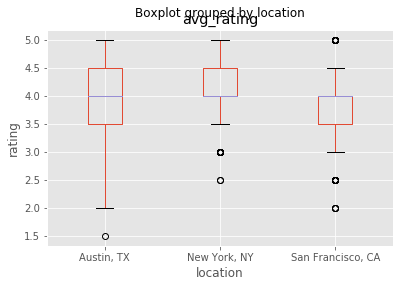

In [184]:
x = df[['location','avg_rating']]
x.boxplot(by='location', column = 'avg_rating')
plt.ylabel('rating')

Text(0, 0.5, 'price')

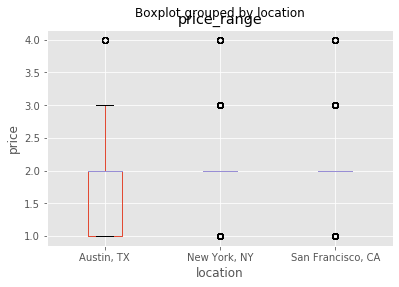

In [432]:
x = df[['location','price_range']]
x.boxplot(by='location', column = 'price_range')
plt.ylabel('price')

Text(0, 0.5, 'price')

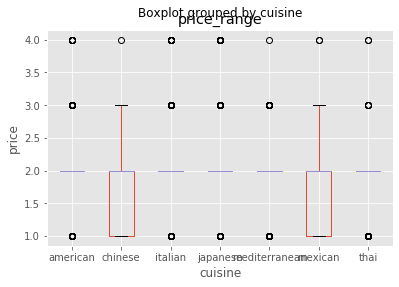

In [433]:
x = df[['cuisine','price_range']]
x.boxplot(by='cuisine', column = 'price_range')
plt.ylabel('price')

(array([ 911.,    0.,    0., 3159.,    0.,    0.,  280.,    0.,    0.,
          71.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

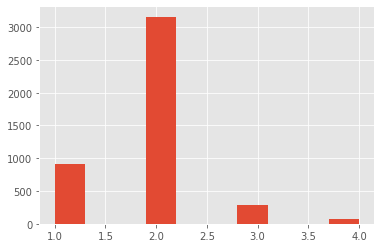

In [434]:
plt.hist(df.price_range)

(array([1.000e+00, 7.000e+00, 4.100e+01, 0.000e+00, 1.940e+02, 9.180e+02,
        0.000e+00, 2.385e+03, 1.081e+03, 1.150e+02]),
 array([1.5 , 1.85, 2.2 , 2.55, 2.9 , 3.25, 3.6 , 3.95, 4.3 , 4.65, 5.  ]),
 <a list of 10 Patch objects>)

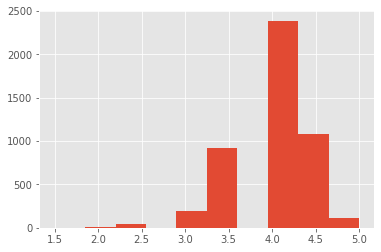

In [122]:
plt.hist(df.avg_rating)

3.960981678353314

(array([4.259e+03, 3.630e+02, 6.900e+01, 2.400e+01, 1.600e+01, 6.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.0000e+01, 1.1114e+03, 2.2128e+03, 3.3142e+03, 4.4156e+03,
        5.5170e+03, 6.6184e+03, 7.7198e+03, 8.8212e+03, 9.9226e+03,
        1.1024e+04]),
 <a list of 10 Patch objects>)

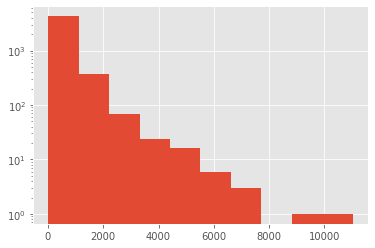

In [124]:
plt.hist(df.num_reviews, log = True)